In [12]:
# Import dependencies
import twitter_functions as tf # custom functions file

from nltk.featstruct import _default_fs_class
import twitter_functions as tf # custom functions file
import streamlit as st
from streamlit_metrics import metric, metric_row
from PIL import Image
import pandas as pd
import datetime as dt
import base64
import tweepy as tw
import yaml
import string
import re
import unicodedata
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import altair as alt
import gensim
from gensim.utils import simple_preprocess

In [2]:
#-----------------------------------#
# 3) GET DATA FROM TWITTER API
#-----------------------------------#

## Set up Twitter API access
# Reference: https://gist.github.com/radcliff/47af9f6238c95f6ae239
# Load yml file to dictionary
credentials = yaml.load(open('./credentials.yml'), Loader=yaml.FullLoader)

# Define access keys and tokens
consumer_key = credentials['twitter_api']['consumer_key']
consumer_secret = credentials['twitter_api']['consumer_secret']
access_token = credentials['twitter_api']['access_token']
access_token_secret = credentials['twitter_api']['access_token_secret']

auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit = True)

# define parameters for API request
search_word = "#rstats"
num_of_tweets = 300
include_retweets = False
language = "en"

if include_retweets == False:
    search_word = search_word + " -filter:retweets"

tweets = tw.Cursor(api.search,
                    q=search_word,
                    tweet_mode = "extended",
                    lang=language).items(num_of_tweets)

tweet_metadata = [[tweet.created_at, tweet.id, tweet.full_text, tweet.user.screen_name, tweet.retweet_count, tweet.favorite_count] for tweet in tweets]

In [3]:
# Store as dataframe
df_tweets = pd.DataFrame(data=tweet_metadata, columns=['created_at', 'id', 'full_text', 'user', 'rt_count', 'fav_count'])

# Add a new data variable
df_tweets['created_dt'] = df_tweets['created_at'].dt.date

# Add a new time variable
df_tweets['created_time'] = df_tweets['created_at'].dt.time

# Create a new text variable to do manipulations on 
df_tweets['clean_text'] = df_tweets.full_text

# Run function #2: Feature extraction
df_tweets = tf.feature_extract(df_tweets)

# Run function #3: Round 1 text cleaning (convert to lower, remove numbers, @, punctuation, numbers. etc.)
df_tweets['clean_text'] = df_tweets.clean_text.apply(tf.text_clean_round1)

# Run function #4: Round 2 text cleaning (create list of tokenized words)
#TODO NOT RUNNING -- FIX?
#df_tweets.clean_text  = tf.text_clean_round2(df_tweets.clean_text)

## Run function #5: Round 3 text cleaning (remove stop words)
df_tweets.clean_text  = tf.text_clean_round3(df_tweets.clean_text)

# Create list of words
words2 = df_tweets.clean_text.tolist()

# Method 1

In [4]:
# Reference: https://ourcodingclub.github.io/tutorials/topic-modelling-python/
# the vectorizer object will be used to transform text to vector form
vectorizer = CountVectorizer(max_df=0.9, min_df=25, token_pattern='\w+|\$[\d\.]+|\S+')

# apply transformation
tf = vectorizer.fit_transform(df_tweets['clean_text']).toarray()

# tf_feature_names tells us what word each column in the matrix represents
tf_feature_names = vectorizer.get_feature_names()

print(tf_feature_names)

['100daysofcode', '100daysofmlcode', 'analytics', 'bigdata', 'cloudcomputing', 'code', 'coding', 'data', 'datascience', 'datascientist', 'iiot', 'iot', 'java', 'javascript', 'linux', 'machinelearning', 'programming', 'python', 'r', 'reactjs', 'serverless', 'tensorflow', 'tidyverse']


In [5]:
number_of_topics = 10

model = LDA(n_components=number_of_topics, random_state=0)

model.fit(tf)

LatentDirichletAllocation(random_state=0)

In [6]:
def lda_topics(data, number_of_topics):
    # the vectorizer object will be used to transform text to vector form
    vectorizer = CountVectorizer(max_df=0.9, min_df=25, token_pattern='\w+|\$[\d\.]+|\S+')

    # apply transformation
    tf = vectorizer.fit_transform(data).toarray()

    # tf_feature_names tells us what word each column in the matrix represents
    tf_feature_names = vectorizer.get_feature_names()

    model = LDA(n_components=number_of_topics, random_state=0)

    return model.fit(tf)

lda_topics(df_tweets['clean_text'], 10)

LatentDirichletAllocation(random_state=0)

In [7]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

no_top_words = 10
display_topics(model, tf_feature_names, no_top_words)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights,Topic 6 words,Topic 6 weights,Topic 7 words,Topic 7 weights,Topic 8 words,Topic 8 weights,Topic 9 words,Topic 9 weights
0,analytics,41.0,data,51.1,programming,16.2,datascience,0.1,tidyverse,54.1,datascience,0.1,python,49.4,python,9.6,code,18.0,javascript,16.9
1,serverless,37.7,datascience,27.9,code,15.1,python,0.1,r,45.1,python,0.1,programming,40.5,datascience,5.1,coding,0.1,100daysofcode,15.9
2,python,36.6,python,5.0,linux,11.3,programming,0.1,coding,0.1,programming,0.1,java,39.1,bigdata,5.1,datascience,0.1,machinelearning,15.9
3,100daysofcode,34.4,analytics,0.1,machinelearning,11.1,tidyverse,0.1,data,0.1,tidyverse,0.1,tensorflow,39.0,code,4.2,analytics,0.1,datascience,15.5
4,datascience,32.5,tensorflow,0.1,reactjs,10.2,100daysofcode,0.1,python,0.1,100daysofcode,0.1,bigdata,38.1,iot,3.7,r,0.1,python,15.3
5,machinelearning,25.9,serverless,0.1,bigdata,10.1,javascript,0.1,programming,0.1,javascript,0.1,datascientist,37.8,100daysofcode,3.3,python,0.1,100daysofmlcode,11.9
6,iot,25.4,100daysofcode,0.1,iot,9.6,coding,0.1,datascience,0.1,coding,0.1,analytics,37.2,machinelearning,3.3,programming,0.1,serverless,8.8
7,bigdata,23.1,coding,0.1,serverless,8.8,machinelearning,0.1,javascript,0.1,machinelearning,0.1,machinelearning,36.3,100daysofmlcode,2.1,bigdata,0.1,iot,4.0
8,iiot,22.5,bigdata,0.1,python,8.7,iot,0.1,analytics,0.1,iot,0.1,datascience,35.8,r,0.1,machinelearning,0.1,programming,2.3
9,tensorflow,21.2,reactjs,0.1,javascript,8.3,r,0.1,code,0.1,r,0.1,coding,35.2,serverless,0.1,cloudcomputing,0.1,bigdata,0.1


# Method 2

C:\Users\shlo\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


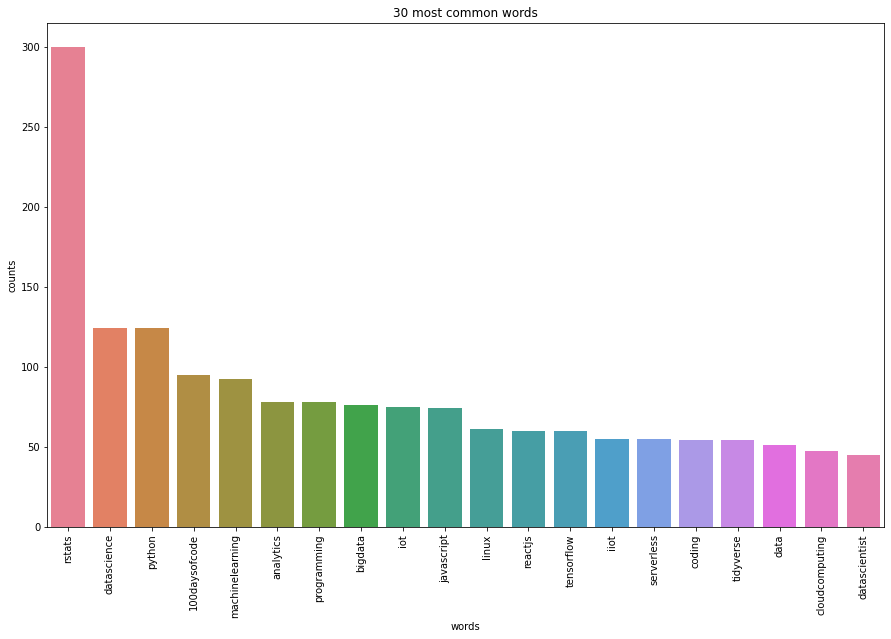

In [8]:
# Helper function
def plot_30_most_common_words(count_data, count_vectorizer):
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:20]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='30 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the processed transcripts
count_data = count_vectorizer.fit_transform(df_tweets['clean_text'])

# Visualise the 30 most common words
plot_30_most_common_words(count_data, count_vectorizer)

In [20]:
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 5
number_words = 30
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

C:\Users\shlo\AppData\Local\Programs\Python\Python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Topics found via LDA:

Topic #0:
rstats tidyverse time package code using chart like reactive makes data learn use check error text create plotly ggplot2 values shiny ggplot excel ti1 ti2 input review functions trouble changing

Topic #1:
rstats na datascience data tidyverse updates cran package ggplot2 line patterns time used viewport wang tuo nas returns length nest periods current vector errors seeimage1 north make based im rayshader

Topic #2:
rstats cran tidyverse learning updates new video online patterns club book community data package update axis pattern regression ros01 stories chapter doesnt mone

Reference: https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

In [21]:
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

C:\Users\shlo\AppData\Local\Programs\Python\Python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
data_words = list(sent_to_words(df_tweets['clean_text']))

print(data_words[:1][0][:30])

['apparently', 'people', 'dont', 'like', 'new', 'rstats', 'pipe', 'image']
C:\Users\shlo\AppData\Local\Programs\Python\Python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

C:\Users\shlo\AppData\Local\Programs\Python\Python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2021-06-21 16:23:21.134 INFO    gensim.corpora.dictionary: adding document #0 to Dictionary(0 unique tokens: [])
2021-06-21 16:23:21.145 INFO    gensim.corpora.dictionary: built Dictionary(1642 unique tokens: ['apparently', 'dont', 'image', 'like', 'new']...) from 300 documents (total 4741 corpus positions)
2021-06-21 16:23:21.146 INFO    gensim.utils: Dictionary lifecycle event {'msg': "built Dictionary(1642 unique tokens: ['apparently', 'dont', 'image', 'like', 'new']...) from 300 documents (total 4741 corpus positions)", 'datetime': '2021-06-21T16:23:21.146498', 'gensim': '4.0.1', 'python': '3.8.10 (tags

In [24]:
from pprint import pprint
# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

C:\Users\shlo\AppData\Local\Programs\Python\Python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2021-06-21 16:23:21.320 INFO    gensim.models.ldamodel: using symmetric alpha at 0.1
2021-06-21 16:23:21.321 INFO    gensim.models.ldamodel: using symmetric eta at 0.1
2021-06-21 16:23:21.322 INFO    gensim.models.ldamodel: using serial LDA version on this node
2021-06-21 16:23:21.325 INFO    gensim.models.ldamulticore: running online LDA training, 10 topics, 1 passes over the supplied corpus of 300 documents, updating every 6000 documents, evaluating every ~300 documents, iterating 50x with a convergence threshold of 0.001000
2021-06-21 16:23:21.326 WARNING gensim.models.ldamulticore: too few updates, trai

In [25]:
import pyLDAvis.gensim_models
import pickle 
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

C:\Users\shlo\AppData\Local\Programs\Python\Python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.140635 -0.032476       1        1  26.292987
3     -0.035876  0.157646       2        1  13.589925
7      0.009658  0.032794       3        1   9.606973
5      0.056284 -0.009446       4        1   8.947608
4      0.072207 -0.014114       5        1   8.645583
2     -0.026130  0.008624       6        1   8.597457
0     -0.123038 -0.089564       7        1   8.259000
1      0.024986 -0.051483       8        1   7.147014
6      0.018100  0.010831       9        1   5.500300
8     -0.136826 -0.012811      10        1   3.413153, topic_info=               Term        Freq       Total Category  logprob  loglift
7            rstats  222.000000  222.000000  Default  30.0000  30.0000
194      tensorflow   54.000000   54.000000  Default  29.0000  29.0000
191     programming   62.000000   62.000000  Default  28.0000  28.0000
178       analytics   67.000000   67.000000  Default  27.0000  27.0000
183   datascientist   39.000000   39.000000  Default  26.0000  26.0000
...             ...         ...         ...      ...      ...      ...
1013          liked    0.595319    3.443459  Topic10  -5.6051   1.6224
197            iiot    0.595316   47.887646  Topic10  -5.6051  -1.0100
486        function    0.595315    4.238152  Topic10  -5.6051   1.4147
192         reactjs    0.595310   52.377613  Topic10  -5.6051  -1.0996
16             data    0.595308   42.064782  Topic10  -5.6051  -0.8804

[655 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
333       7  0.711236      added
1070      1  0.763558  affiliate
1070      7  0.152712  affiliate
93        6  0.535959   aircraft
841       3  0.319182      alert
...     ...       ...        ...
582      10  0.330291      would
332       4  0.528539      wrong
868       2  0.442657    ymlthis
1078      1  0.763939         yt
1078      7  0.190985         yt

[924 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 4, 8, 6, 5, 3, 1, 2, 7, 9])